# Preprocessing Data 


In [0]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn import svm, metrics

%matplotlib inline
import os
import re
print(os.listdir("/content"))

# New Section

In [12]:
df = pd.read_json("/content/Sarcasm_Headlines_Dataset.json", lines=True)
df = df.drop(['article_link'], axis=1)
df['headline_count'] = df.headline.apply(lambda x: len(list(x.split())))
df['headline_unique_word_count'] = df.headline.apply(lambda x: len(set(x.split())))
df['headline_has_digits'] = df.headline.apply(lambda x: bool(re.search(r'\d', x)))
df['length'] = df['headline'].apply(lambda x: len(x.split(" ")))

df.head()

,headline,is_sarcastic,headline_count,headline_unique_word_count,headline_has_digits,length
0,former versace store clerk sues over secret 'b...,0,12,12,False,12
1,the 'roseanne' revival catches up to our thorn...,0,14,14,False,14
2,mom starting to fear son's web series closest ...,1,14,13,False,14
3,"boehner just wants wife to listen, not come up...",1,13,13,False,13
4,j.k. rowling wishes snape happy birthday in th...,0,11,11,False,11


,headline,is_sarcastic,headline_count,headline_unique_word_count,headline_has_digits,length
0,former versace store clerk sues over secret 'b...,0,12,12,False,12
1,the 'roseanne' revival catches up to our thorn...,0,14,14,False,14
2,mom starting to fear son's web series closest ...,1,14,13,False,14
3,"boehner just wants wife to listen, not come up...",1,13,13,False,13
4,j.k. rowling wishes snape happy birthday in th...,0,11,11,False,11


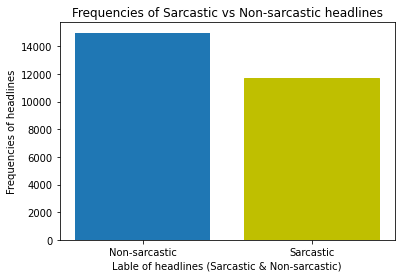

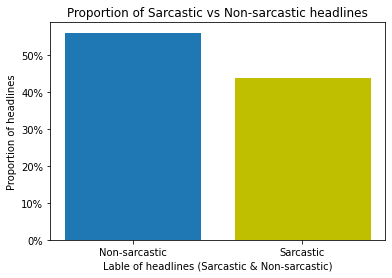

Non-sarcastic    0.56
Sarcastic        0.44
Name: headline_count, dtype: float64

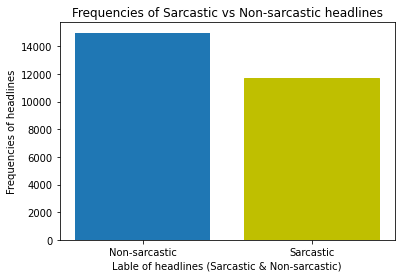

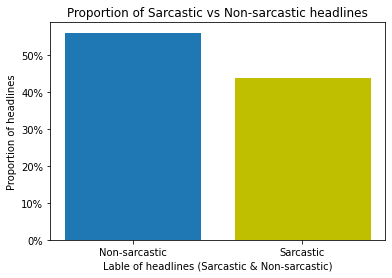

Non-sarcastic    0.56
Sarcastic        0.44
Name: headline_count, dtype: float64

In [13]:
sarcastic_dat = df.groupby('is_sarcastic').count()
sarcastic_dat.index = ['Non-sarcastic','Sarcastic']
plt.xlabel('Lable of headlines (Sarcastic & Non-sarcastic)')
plt.ylabel('Frequencies of headlines')
plt.xticks(fontsize=10)
plt.title('Frequencies of Sarcastic vs Non-sarcastic headlines')
bar_graph = plt.bar(sarcastic_dat.index, sarcastic_dat.headline_count)
bar_graph[1].set_color('y')
plt.show()

plt.xlabel('Lable of headlines (Sarcastic & Non-sarcastic)')
plt.ylabel('Proportion of headlines')
plt.xticks(fontsize=10)
plt.title('Proportion of Sarcastic vs Non-sarcastic headlines')
bar_graph = plt.bar(sarcastic_dat.index, sarcastic_dat.headline_count / sarcastic_dat.headline_count.sum())
bar_graph[1].set_color('y')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

# This is not an imbalanced class dataset
# Non-sarcastic    0.56
# Sarcastic        0.44
round(sarcastic_dat.headline_count / sarcastic_dat.headline_count.sum(), 2)

#Creating Embedding Matrix by Pre-Trained Glove Word Vectors


In [0]:
max_features = 10000
maxlen = 100
embedding_size = 50

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(df['headline']))
X = tokenizer.texts_to_sequences(df['headline'])
X = pad_sequences(X, maxlen = maxlen)
Y = df['is_sarcastic']

In [15]:
word_index = tokenizer.word_index
num_words = min(max_features, len(word_index))

WordEM_FILE="/content/glove.6B.50d.txt"
def get_coefs(word,*arr): 
  return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split(" ")) for o in open(WordEM_FILE) if len(o)>100)

word_em = np.column_stack(embeddings_index.values())
em_mean, em_std = word_em.mean(), word_em.std()
embed_size = word_em.shape[1]

embedding_matrix = np.random.normal(em_mean, em_std, (num_words, embedding_size))
for word, i in word_index.items():
    if i >= max_features: 
      continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if __name__ == '__main__':


# Train LSTM model

Epoch 1/20
24/24 [==============================] - 1s 34ms/step - loss: 1.0326 - accuracy: 0.5441
Epoch 2/20
24/24 [==============================] - 1s 34ms/step - loss: 0.9145 - accuracy: 0.5861
Epoch 3/20
24/24 [==============================] - 1s 34ms/step - loss: 0.8479 - accuracy: 0.6177
Epoch 4/20
24/24 [==============================] - 1s 34ms/step - loss: 0.7787 - accuracy: 0.6592
Epoch 5/20
24/24 [==============================] - 1s 34ms/step - loss: 0.6968 - accuracy: 0.7144
Epoch 6/20
24/24 [==============================] - 1s 34ms/step - loss: 0.6186 - accuracy: 0.7640
Epoch 7/20
24/24 [==============================] - 1s 34ms/step - loss: 0.5507 - accuracy: 0.7949
Epoch 8/20
24/24 [==============================] - 1s 34ms/step - loss: 0.4974 - accuracy: 0.8183
Epoch 9/20
24/24 [==============================] - 1s 33ms/step - loss: 0.4570 - accuracy: 0.8373
Epoch 10/20
24/24 [==============================] - 1s 34ms/step - loss: 0.4244 - accuracy: 0.8473
Epoch 11/

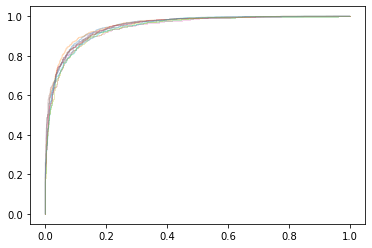

In [17]:
import tensorflow as tf
from keras import regularizers
from sklearn.metrics import roc_curve,auc
from numpy import interp

tprs=[]
aucs=[]
f1_scores = []
mean_fpr=np.linspace(0,1,100)
i = 0
seed = 7
np.random.seed(seed)
# Experimenting 10-fold cross validation test
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, Y):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(max_features, embedding_size, weights = [embedding_matrix]))
  model.add(tf.keras.layers.SpatialDropout1D(0.2))
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
  model.add(tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='relu'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='sigmoid'))
  model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
  history = model.fit(X[train], Y[train], epochs=20, batch_size=1024,verbose=1)
  scores = model.evaluate(X[test], Y[test], verbose=1)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

  y_pred = model.predict(X[test], batch_size=1024, verbose=1)
  one_score = metrics.f1_score(Y[test], y_pred.round(), average='macro')
  f1_scores.append(one_score)

  fpr,tpr,thresholds=roc_curve(Y[test],y_pred) 
  tprs.append(interp(mean_fpr,fpr,tpr))
  tprs[-1][0]=0.0
  roc_auc=auc(fpr,tpr)
  aucs.append(roc_auc)
  plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d(area=%0.2f)'% (i, roc_auc))
  i +=1

model.summary()
cvscores.append(scores[1] * 100)
print("Accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)* 2))
print("Macro f1 score: ", np.mean(f1_scores)
)

# Visualize and Analyze Results

## Accuracy and Loss


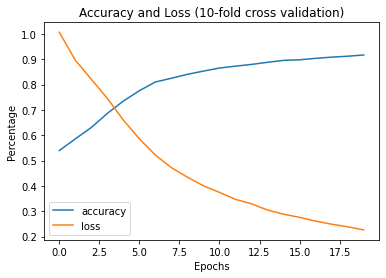

In [0]:
plt.title('Accuracy and Loss (10-fold cross validation)')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.xlabel("Epochs")
plt.ylabel('Percentage')
plt.legend(loc='best')
plt.show()

## Macro F1-Score



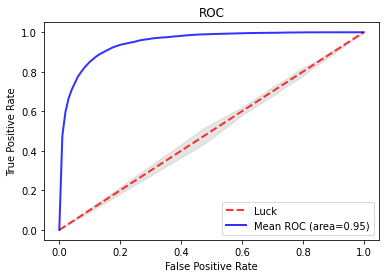

In [0]:
plt.plot([0,1],[0,1],linestyle='--',lw=2,color='r',label='Luck',alpha=.8)
mean_tpr=np.mean(tprs,axis=0)
mean_tpr[-1]=1.0
mean_auc=auc(mean_fpr,mean_tpr)
std_auc=np.std(tprs,axis=0)
plt.plot(mean_fpr,mean_tpr,color='b',label=r'Mean ROC (area=%0.2f)'%mean_auc,lw=2,alpha=.8)
std_tpr=np.std(tprs,axis=0)
tprs_upper=np.minimum(mean_tpr+std_tpr,1)
tprs_lower=np.maximum(mean_tpr-std_tpr,0)
plt.fill_between(mean_tpr,tprs_lower,tprs_upper,color='gray',alpha=.2)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()    

## Model Architecture

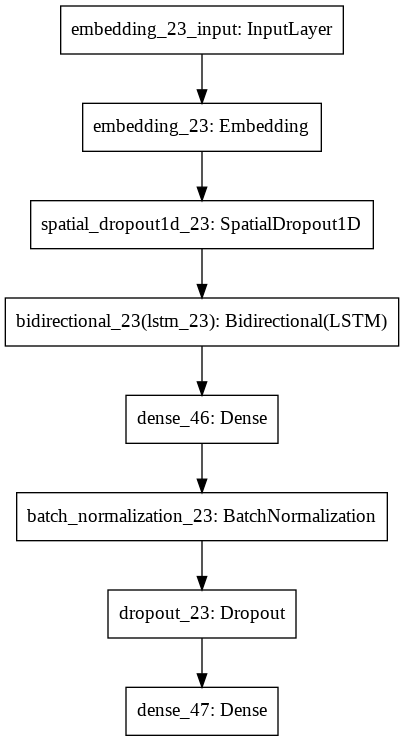

In [21]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')